In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re

nltk.download('vader_lexicon')

tweets_df = pd.read_csv('/content/stock_tweets.csv')

sia = SentimentIntensityAnalyzer()

custom_words = {
    "sell": -2.0,
    "sold": -2.0,
    "buy": 2.0,
    "bought": 2.0,
    "bullish": 2.0,
    "bearish": -2.0,
    "profit": 1.2,
    "loss": -1.2,
    "top app": 1.5,
    "#1 app": 1.8,
    "next level": 1.3,
    "long": 2.5,
    "short": -2.5
}
sia.lexicon.update(custom_words)

def contextual_sentiment_score(text):
    score = sia.polarity_scores(text)['compound']

    if re.search(r'\boculus\b', text, re.IGNORECASE):
        if re.search(r'\b(old|outdated|clunky|worse|disappointing)\b', text, re.IGNORECASE):
            score -= 0.8
        elif re.search(r'\b(better|improved|next level|#1)\b', text, re.IGNORECASE):
            score += 0.5

    return score

tweets_df['sentiment_score'] = tweets_df['Tweet'].apply(contextual_sentiment_score)

tweets_df.to_csv('/content/sentiment_scored_tweets.csv', index=False)

print("Sentiment scores with contextual adjustments have been saved as 'sentiment_scored_tweets.csv'")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment scores with contextual adjustments have been saved as 'sentiment_scored_tweets.csv'


In [ ]:
stock_df = pd.read_csv('/content/stock_yfinance_data.csv')

stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date

daily_sentiment = tweets_df.groupby(['Date', 'Stock Name']).agg({'sentiment_score': 'mean'}).reset_index()
daily_sentiment.rename(columns={'sentiment_score': 'daily_sentiment_score'}, inplace=True)

merged_df = pd.merge(stock_df, daily_sentiment, how='inner', left_on=['Date', 'Stock Name'], right_on=['Date', 'Stock Name'])

merged_df.to_csv('/content/merged_stock_sentiment_data.csv', index=False)

print("Merged dataset with daily sentiment scores and stock data has been saved as 'merged_stock_sentiment_data.csv'")


Merged dataset with daily sentiment scores and stock data has been saved as 'merged_stock_sentiment_data.csv'


In [ ]:
correlation = merged_df[['daily_sentiment_score', 'Close', 'Volume']].corr()
print("Correlation Matrix:\n", correlation)

merged_df['daily_return'] = (merged_df['Close'] - merged_df['Open']) / merged_df['Open']

merged_df.to_csv('/content/processed_stock_sentiment_data.csv', index=False)
print("Processed dataset with new features has been saved as 'processed_stock_sentiment_data.csv'")

Correlation Matrix:
                        daily_sentiment_score     Close    Volume
daily_sentiment_score               1.000000 -0.018749 -0.051186
Close                              -0.018749  1.000000 -0.194317
Volume                             -0.051186 -0.194317  1.000000
Processed dataset with new features has been saved as 'processed_stock_sentiment_data.csv'


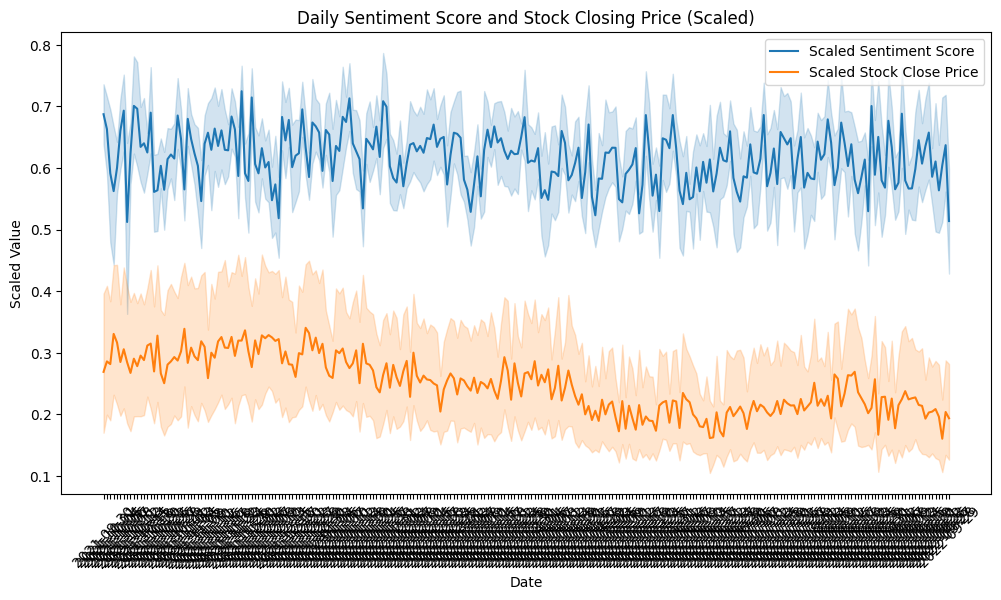

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.read_csv('/content/processed_stock_sentiment_data.csv')

scaler = MinMaxScaler()

merged_df[['scaled_sentiment_score', 'scaled_close']] = scaler.fit_transform(
    merged_df[['daily_sentiment_score', 'Close']]
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Date', y='scaled_sentiment_score', label='Scaled Sentiment Score')
sns.lineplot(data=merged_df, x='Date', y='scaled_close', label='Scaled Stock Close Price')
plt.title('Daily Sentiment Score and Stock Closing Price (Scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()


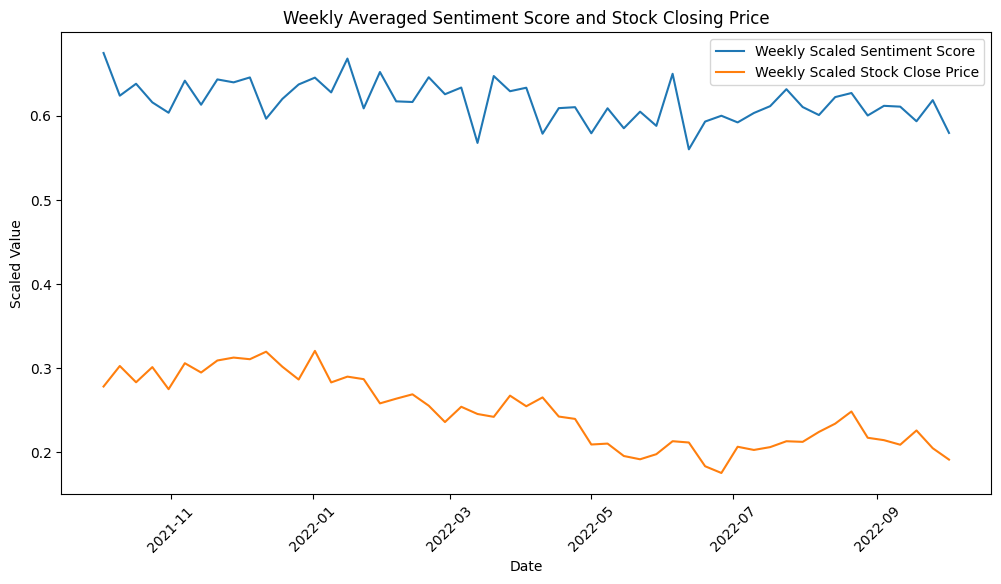

In [ ]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

numeric_cols = merged_df.select_dtypes(include='number').columns
weekly_df = merged_df.set_index('Date')[numeric_cols].resample('W').mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_df, x='Date', y='scaled_sentiment_score', label='Weekly Scaled Sentiment Score')
sns.lineplot(data=weekly_df, x='Date', y='scaled_close', label='Weekly Scaled Stock Close Price')
plt.title('Weekly Averaged Sentiment Score and Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Correlation Matrix with Lagged Sentiment Features:
                        daily_sentiment_score  sentiment_lag_1  \
daily_sentiment_score               1.000000         0.056144   
sentiment_lag_1                     0.056144         1.000000   
sentiment_lag_2                     0.041211         0.055965   
sentiment_lag_3                     0.057605         0.041287   
Close                              -0.018702        -0.019023   
Volume                             -0.051065        -0.054433   

                       sentiment_lag_2  sentiment_lag_3     Close    Volume  
daily_sentiment_score         0.041211         0.057605 -0.018702 -0.051065  
sentiment_lag_1               0.055965         0.041287 -0.019023 -0.054433  
sentiment_lag_2               1.000000         0.055993 -0.021281 -0.039935  
sentiment_lag_3               0.055993         1.000000 -0.016906 -0.036892  
Close                        -0.021281        -0.016906  1.000000 -0.194813  
Volume                  

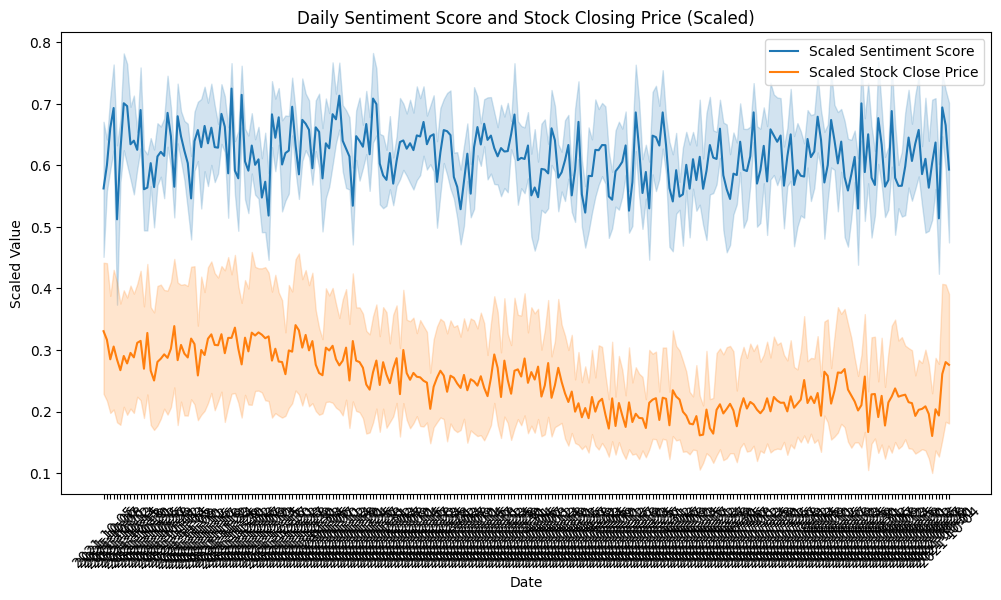

Processed dataset with lagged features has been saved as 'processed_stock_sentiment_with_lags.csv'


In [ ]:
merged_df = pd.read_csv('/content/processed_stock_sentiment_data.csv')

merged_df['sentiment_lag_1'] = merged_df['daily_sentiment_score'].shift(1)
merged_df['sentiment_lag_2'] = merged_df['daily_sentiment_score'].shift(2)
merged_df['sentiment_lag_3'] = merged_df['daily_sentiment_score'].shift(3)

merged_df.dropna(inplace=True)

correlation_lagged = merged_df[['daily_sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3', 'Close', 'Volume']].corr()
print("Correlation Matrix with Lagged Sentiment Features:\n", correlation_lagged)

scaler = MinMaxScaler()

merged_df[['scaled_sentiment_score', 'scaled_close']] = scaler.fit_transform(
    merged_df[['daily_sentiment_score', 'Close']]
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Date', y='scaled_sentiment_score', label='Scaled Sentiment Score')
sns.lineplot(data=merged_df, x='Date', y='scaled_close', label='Scaled Stock Close Price')
plt.title('Daily Sentiment Score and Stock Closing Price (Scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

merged_df.to_csv('/content/processed_stock_sentiment_with_lags.csv', index=False)
print("Processed dataset with lagged features has been saved as 'processed_stock_sentiment_with_lags.csv'")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0254 - val_loss: 0.0030
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

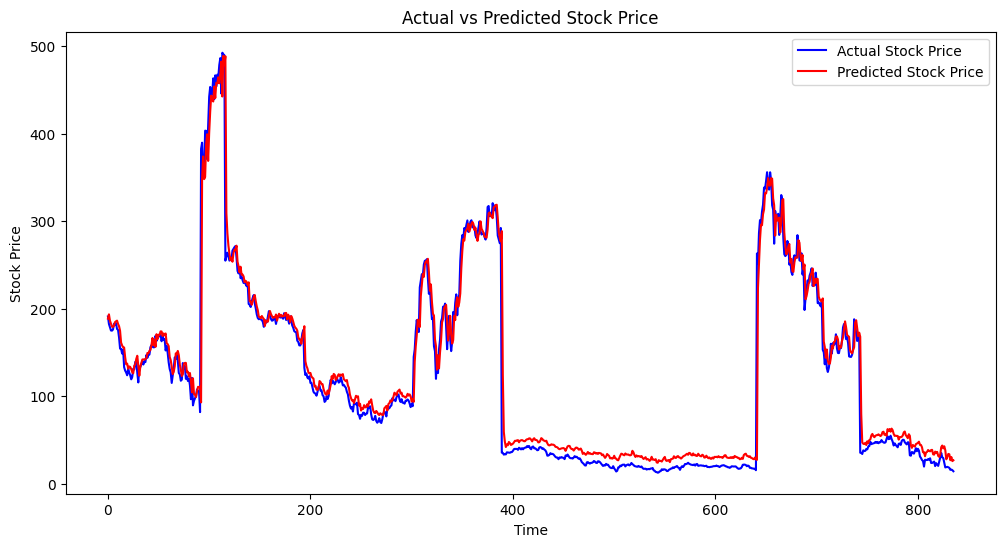

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('/content/processed_stock_sentiment_with_lags.csv')

features = ['Close', 'Volume', 'daily_sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

time_steps = 5

X = []
y = []
for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))), axis=1))[:, 0]

mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Percentage Error (MAPE): 23.922200708393184%
